<a href="https://colab.research.google.com/github/qoyyimil/pba/blob/main/notebooks/2_Preprocessing_Moovit_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing & Analisis Data Review Aplikasi Moovit
Tugas 1A - Pemodelan Bahasa Alami

In [1]:
# --- Instalasi Library ---
!pip install pandas
!pip install Sastrawi
!pip install nltk
!pip install seaborn
!pip install matplotlib
!pip install emoji

# --- Import Library ---
import pandas as pd
import numpy as np
import re
import string
import nltk
import emoji
from collections import Counter

# -- Library Preprocessing --
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# -- Library Visualisasi --
import seaborn as sns
import matplotlib.pyplot as plt

# --- Konfigurasi ---
pd.set_option("display.max_colwidth", 200)
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# -- Download Resource NLTK (cukup sekali) --
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# Load dataset mentah dari file scraping
df = pd.read_csv('moovit_reviews_raw.csv')
print(f"Dataset berhasil dimuat dengan {len(df)} baris.")
df.head(3)

Dataset berhasil dimuat dengan 2829 baris.


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,language
0,48e80d4b-e56b-4800-9236-f00764bc15d2,D********a,https://play-lh.googleusercontent.com/a-/ALV-UjVC0JuzYeMjHxKxh5iAIAQTGilmUz3jdvMIAGnyojo7poL8h4g8rQ,Akurat dan sangat diperlukan,5,0,5.177.3.1748,2025-10-15 01:17:07,NaN,NaN,5.177.3.1748,id
1,8a745e04-dc85-42ca-8519-b9c1b7ba5c4a,A************a,https://play-lh.googleusercontent.com/a-/ALV-UjWrqufOIE0M-7ZYd8C7Gd0MtRgaDwicBfNftoC-EXRwiNZeFFnGXQ,"apk gajelas, waktu keberangkatan jak di moovit ga sesuai malah bikin nyasar orang trs halte juga ga jelas org mah ada fotonya biar jelas & tau😡😡😡. ini apk bnr' ga bisa di pk & banyak iklan, pdhl a...",1,0,5.177.3.1748,2025-10-14 12:43:37,NaN,NaN,5.177.3.1748,id
2,e271b192-0f8d-43a5-a198-d331798af2a6,c**a,https://play-lh.googleusercontent.com/a/ACg8ocK-wUVVaKMMgqMaqGMYTNqbQaCrYwTHqCoetUN3lcCt0MoRxQ=mo,"ga jelas, ga akurat sama sekali sama rute jaklingko !",1,0,NaN,2025-10-14 12:38:39,NaN,NaN,NaN,id


## Pipeline Tahap 1: Pembersihan & Normalisasi Dasar

Pada tahap ini, kita akan melakukan pembersihan awal yang meliputi:
1.  **Lowering**: Mengubah teks menjadi huruf kecil.
2.  **Punctuations Removal**: Menghapus tanda baca, angka, dan karakter spesial.
3.  **Normalization (Spelling Correction & Expand Contractions)**: Mengganti kata-kata slang/singkatan menjadi bentuk baku menggunakan kamus.

In [3]:
# Kamus Normalisasi
normalization_dict = {
    # --- Umum & Sering Digunakan ---
    'yg': 'yang', 'ga': 'tidak', 'gak': 'tidak', 'gk': 'tidak', 'tdk': 'tidak', 'engga': 'tidak', 'ngga': 'tidak',
    'jg': 'juga', 'aja': 'saja', 'tp': 'tapi', 'kalo': 'kalau', 'udh': 'sudah', 'udah': 'sudah', 'sdh': 'sudah',
    'bgt': 'banget', 'utk': 'untuk', 'dgn': 'dengan', 'dr': 'dari', 'dlm': 'dalam', 'trs': 'terus', 'bnyk': 'banyak',
    'byk': 'banyak', 'sll': 'selalu', 'slalu': 'selalu', 'spt': 'seperti', 'kyk': 'seperti', 'kayak': 'seperti',
    'bs': 'bisa', 'gbs': 'tidak bisa', 'gabisa': 'tidak bisa', 'skrg': 'sekarang', 'lg': 'lagi', 'sm': 'sama',
    'emg': 'memang', 'emang': 'memang', 'bkn': 'bukan', 'blm': 'belum', 'blom': 'belum', 'tpi': 'tapi', 'krn': 'karena',
    'karna': 'karena', 'pas': 'saat', 'or': 'atau', 'pake': 'pakai', 'msh': 'masih', 'kek': 'seperti', 'hny': 'hanya',
    'org': 'orang', 'kpd': 'kepada', 'skrng': 'sekarang', 'sy': 'saya', 'tau': 'tahu', 'gini': 'begini', 'gitu': 'begitu',
    'dah': 'sudah', 'tuh': 'itu', 'deh': '', 'sih': '', 'dong': '', 'kok': '', 'nih': 'ini',

    # --- Kata Ganti & Tanya ---
    'gw': 'saya', 'gua': 'saya', 'sy': 'saya', 'aq': 'aku', 'loe': 'kamu', 'elu': 'kamu', 'anda': 'anda', 'doi': 'dia',
    'gmn': 'bagaimana', 'gimana': 'bagaimana', 'bgmn': 'bagaimana', 'apaan': 'apa', 'kpn': 'kapan', 'dimn': 'di mana',
    'knp': 'kenapa', 'kenpa': 'kenapa', 'mengapa': 'mengapa',

    # --- Waktu & Tempat ---
    'dlu': 'dulu', 'ntar': 'nanti', 'besok': 'besok', 'skrg': 'sekarang', 'tdi': 'tadi', 'barusan': 'baru saja',
    'dsni': 'di sini', 'disitu': 'di situ', 'kesana': 'ke sana', 'kesini': 'ke sini', 'kemaren': 'kemarin', 'kmrn': 'kemarin',

    # --- Respons & Seruan (beberapa sengaja dihilangkan dengan string kosong) ---
    'ok': 'oke', 'oke': 'oke', 'sip': 'sip', 'mantap': 'mantap', 'makasih': 'terima kasih', 'mksh': 'terima kasih',
    'mksih': 'terima kasih', 'thanks': 'terima kasih', 'thx': 'terima kasih', 'maap': 'maaf', 'maf': 'maaf',
    'tolong': 'tolong', 'tlg': 'tolong', 'pls': 'tolong', 'plis': 'tolong', 'wkwk': '', 'hehe': '', 'haha': '', 'xixi': '',
    'astaga': 'astaga', 'anjir': '', 'anjay': '', 'parah': 'parah', 'sbnrnya': 'sebenarnya', 'sbnre': 'sebenarnya',
    'sumpah': 'sumpah', 'bener': 'benar', 'betul': 'betul', 'beneran': 'benaran', 'serius': 'serius', 'fix': 'pasti',
    'lope': '', 'dehh': '',

    # --- Istilah Aplikasi & Teknologi ---
    'apk': 'aplikasi', 'app': 'aplikasi', 'apps': 'aplikasi', 'update': 'pembaruan', 'download': 'unduh', 'donlot': 'unduh',
    'instal': 'pasang', 'install': 'pasang', 'eror': 'error', 'bug': 'bug', 'ngebug': 'bug', 'crash': 'crash',
    'ngecrash': 'crash', 'lag': 'lag', 'ngelag': 'lag', 'lemot': 'lambat', 'notif': 'notifikasi', 'iklan': 'iklan',
    'fitur': 'fitur', 'akun': 'akun', 'login': 'masuk', 'logout': 'keluar', 'username': 'nama pengguna',
    'password': 'kata sandi', 'email': 'email', 'verifikasi': 'verifikasi', 'kode': 'kode', 'otp': 'otp', 'aps': 'aplikasi',
    'jaringan': 'jaringan', 'sinyal': 'sinyal', 'koneksi': 'koneksi', 'internet': 'internet', 'data': 'data', 'web': 'situs web', 'movit': 'moovit',

    # --- Singkatan Verba (Kata Kerja) ---
    'ngomong': 'bicara', 'ngobrol': 'berbincang', 'ngeliat': 'melihat', 'liat': 'lihat', 'ngasih': 'memberi',
    'kasih': 'beri', 'ngambil': 'mengambil', 'ngerti': 'mengerti', 'ngalamin': 'mengalami', 'nyoba': 'mencoba',
    'coba': 'coba', 'bikin': 'membuat', 'buat': 'untuk', 'nunggu': 'menunggu', 'nyari': 'mencari',
    'cari': 'cari', 'bilang': 'berkata', 'nanya': 'bertanya', 'tanya': 'tanya', 'masukin': 'memasukkan',
    'dateng': 'datang', 'pindah': 'pindah', 'ngikutin': 'mengikuti', 'ngelakuin': 'melakukan', 'dapet': 'dapat', 'dpt': 'dapat',

    # --- Typo Umum & Variasi ---
    'tdak': 'tidak', 'tidk': 'tidak', 'tapi': 'tapi', 'tapii': 'tapi', 'sangat': 'sangat', 'sangatt': 'sangat',
    'baguss': 'bagus', 'jelek': 'jelek', 'jelekk': 'jelek', 'tolongg': 'tolong', 'kenapaa': 'kenapa', 'karna': 'karena',
    'tyt': 'ternyata', 'tolong': 'tolong', 'tolongin': 'tolong', 'mohon': 'mohon', 'moga': 'semoga', 'smoga': 'semoga',
    'kesel': 'kesal', 'kecewa': 'kecewa', 'kurang': 'kurang', 'mantul': 'mantap betul', 'recomended': 'rekomendasi',
    'membantuu': 'membantu', 'gangu': 'ganggu', 'iklanya': 'iklan', 'god': 'good',

    # --- PENAMBAHAN BARU DARI TEMUAN BoW ---
    'aj': 'saja',
    'abis': 'habis',
    'acurate': 'akurat',
    'god': 'bagus',
    'gajelas': 'tidak jelas',
    'jak': 'jaklingko',
    'bnr': 'benar',
    'pdhl': 'padahal',
    'nongol': 'muncul',
    'mending': 'lebih baik',
    'dh': 'sudah',
    'ni': 'ini',
    'trs': 'terus',
    'org': 'orang',
    'akhirakhir': 'akhir-akhir',
    'aktifitas': 'aktivitas',
    'acurate': 'akurat'
}

def normalize_and_clean(text):
    text = str(text).lower()  # 1. Lowercasing

    # 2. Menghapus karakter berulang (misal: "sangatttt" -> "sanggat")
    text = re.sub(r'(.)\1+', r'\1', text)

    # 3. Hapus URL, mention, hashtag
    text = re.sub(r'https?:\/\/\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)

    # 4. Hapus emoji
    text = emoji.replace_emoji(text, replace='')

    # 5. Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 6. Hapus angka
    text = re.sub(r'\d+', '', text)

    # 7. Normalisasi kata menggunakan kamus
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    text = ' '.join(normalized_words)

    # 8. Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['content_cleaned'] = df['content'].apply(normalize_and_clean)
print("Tahap 1 (Pembersihan & Normalisasi) selesai.")
df[['content', 'content_cleaned']].head()

Tahap 1 (Pembersihan & Normalisasi) selesai.


,content,content_cleaned
0,Akurat dan sangat diperlukan,akurat dan sangat diperlukan
1,"apk gajelas, waktu keberangkatan jak di moovit ga sesuai malah bikin nyasar orang trs halte juga ga jelas org mah ada fotonya biar jelas & tau😡😡😡. ini apk bnr' ga bisa di pk & banyak iklan, pdhl a...",aplikasi tidak jelas waktu keberangkatan jaklingko di moovit tidak sesuai malah membuat nyasar orang terus halte juga tidak jelas orang mah ada fotonya biar jelas tahu ini aplikasi benar tidak bis...
2,"ga jelas, ga akurat sama sekali sama rute jaklingko !",tidak jelas tidak akurat sama sekali sama rute jaklingko
3,gw instal lu ko makin ribet sih anj,saya pasang lu ko makin ribet anj
4,"apk tolol, salah klik iklan blog bgt ni apk",aplikasi tolol salah klik iklan blog banget ini aplikasi


## Pipeline Tahap 2: Tokenization, Stopwords, & Stemming

Langkah selanjutnya adalah:
1.  **Tokenization**: Memecah kalimat menjadi token (kata).
2.  **Stopword Removal**: Menghapus kata-kata umum dari daftar awal NLTK.
3.  **Stemming**: Mengubah kata ke bentuk dasarnya (ini mencakup tujuan **Lemmatization** dalam konteks Bahasa Indonesia).

In [4]:
# 1. Tokenization
df['tokenized'] = df['content_cleaned'].apply(word_tokenize)

# 2. Stopword Removal (Initial)
initial_stopwords = set(stopwords.words('indonesian'))

def remove_initial_stopwords(tokens):
    return [word for word in tokens if word not in initial_stopwords]

df['no_stopwords_initial'] = df['tokenized'].apply(remove_initial_stopwords)

# 3. Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

df['stemmed'] = df['no_stopwords_initial'].apply(stem_tokens)

print("Tahap 2 (Tokenize, Stopwords Awal, Stemming) selesai.")
df[['content_cleaned', 'stemmed']].head()

Tahap 2 (Tokenize, Stopwords Awal, Stemming) selesai.


,content_cleaned,stemmed
0,akurat dan sangat diperlukan,[akurat]
1,aplikasi tidak jelas waktu keberangkatan jaklingko di moovit tidak sesuai malah membuat nyasar orang terus halte juga tidak jelas orang mah ada fotonya biar jelas tahu ini aplikasi benar tidak bis...,"[aplikasi, berangkat, jaklingko, moovit, sesuai, nyasar, orang, halte, orang, mah, foto, biar, aplikasi, pk, iklan, aplikasi, iklan, hdh, sesuai, tera, aplikasi, tulis, muncul, jaklingko, apus, ap..."
2,tidak jelas tidak akurat sama sekali sama rute jaklingko,"[akurat, rute, jaklingko]"
3,saya pasang lu ko makin ribet anj,"[pasang, lu, ko, ribet, anj]"
4,aplikasi tolol salah klik iklan blog banget ini aplikasi,"[aplikasi, tolol, salah, klik, iklan, blog, banget, aplikasi]"


## Pipeline Tahap 3: Analisis Frekuensi & Pembersihan Lanjutan

Data yang sudah di-*stem* masih mungkin mengandung kata yang tidak relevan. Kita akan:
1.  **Menghitung Frekuensi Kata**: Untuk menemukan kata yang terlalu umum (*common*) dan terlalu jarang (*rare*).
2.  **Identifikasi Stopwords Baru**: Dari daftar kata paling umum, kita pilih kata-kata yang spesifik untuk konteks ini (misal: "moovit", "aplikasi") untuk ditambahkan ke daftar stopwords.
3.  **Rare Words Removal**: Menghapus kata-kata yang sangat jarang muncul (misal, hanya muncul sekali) karena biasanya tidak memberikan informasi signifikan (seringkali typo).
4.  **Final Stopword Removal**: Mengulangi proses penghapusan stopwords dengan daftar yang sudah diperbarui.

In [5]:
# Gabungkan semua token menjadi satu list besar
all_tokens = [word for tokens in df['stemmed'] for word in tokens]

# Hitung frekuensi setiap kata
word_freq = Counter(all_tokens)

# Tampilkan 50 kata paling umum
print("Top 50 Kata Paling Umum (Sebelum Final Cleaning):")
print(word_freq.most_common(50))

# Identifikasi Rare Words (contoh: yang muncul hanya 1 kali)
rare_words = {word for word, count in word_freq.items() if count <= 1}
print(f"\nJumlah kata langka (frekuensi <= 1): {len(rare_words)}")

# Identifikasi Stopwords Baru dari kata yang paling umum
new_stopwords = {
    'moovit', 'aplikasi', 'banget', 'terima', 'kasih', 'bagus', 'bantu', 'baik',
    'ku', 'gara', 'mah', 'solutif', 'nya', 'deh', 'sih', 'kok', 'pas', 'cek',
    'unduh', 'inti', 'gogle', 'ap', 'iklanya', 'gangu', 'ah', 'ya', 'ad', 'ads',
    'abang', 'ajar', 'tera', 'jaklingko'
}

# Buat daftar stopwords final
final_stopwords = initial_stopwords.union(new_stopwords)
print(f"\nJumlah stopwords awal: {len(initial_stopwords)}")
print(f"Jumlah stopwords final: {len(final_stopwords)}")

Top 50 Kata Paling Umum (Sebelum Final Cleaning):
[('aplikasi', 579), ('bantu', 563), ('bagus', 434), ('iklan', 310), ('nya', 217), ('rute', 198), ('jadwal', 189), ('banget', 177), ('oke', 156), ('bus', 152), ('akurat', 145), ('jalan', 127), ('moovit', 115), ('jam', 115), ('mudah', 102), ('sesuai', 101), ('baru', 99), ('pakai', 95), ('coba', 94), ('cari', 89), ('mantap', 83), ('ya', 76), ('transportasi', 74), ('terima', 72), ('tolong', 69), ('ap', 68), ('baik', 67), ('datang', 64), ('busway', 58), ('kota', 57), ('tuju', 56), ('guna', 54), ('bis', 54), ('bayar', 49), ('menit', 49), ('halte', 48), ('bintang', 48), ('mana', 48), ('lihat', 47), ('keren', 46), ('orang', 45), ('unduh', 45), ('kendaran', 45), ('transjakarta', 45), ('kasih', 44), ('suka', 44), ('bermanfat', 43), ('banyak', 42), ('angkut', 41), ('jakarta', 41)]

Jumlah kata langka (frekuensi <= 1): 1743

Jumlah stopwords awal: 757
Jumlah stopwords final: 787


In [6]:
def final_cleaning(tokens):
    # Hapus stopwords dari daftar final
    tokens_no_final_stopwords = [word for word in tokens if word not in final_stopwords]
    # Hapus rare words
    tokens_no_rare = [word for word in tokens_no_final_stopwords if word not in rare_words]
    return tokens_no_rare

# Terapkan pembersihan final
df['final_tokens'] = df['stemmed'].apply(final_cleaning)

# Buat kolom teks bersih final
df['final_content'] = df['final_tokens'].apply(lambda x: ' '.join(x))

print("Tahap 3 (Pembersihan Lanjutan) selesai.")
df[['content', 'final_content']].head()

Tahap 3 (Pembersihan Lanjutan) selesai.


,content,final_content
0,Akurat dan sangat diperlukan,akurat
1,"apk gajelas, waktu keberangkatan jak di moovit ga sesuai malah bikin nyasar orang trs halte juga ga jelas org mah ada fotonya biar jelas & tau😡😡😡. ini apk bnr' ga bisa di pk & banyak iklan, pdhl a...",berangkat sesuai nyasar orang halte orang foto biar iklan iklan sesuai tulis muncul bintang ksh bintang
2,"ga jelas, ga akurat sama sekali sama rute jaklingko !",akurat rute
3,gw instal lu ko makin ribet sih anj,pasang lu ko ribet
4,"apk tolol, salah klik iklan blog bgt ni apk",tolol salah klik iklan


## Simpan & Analisis Hasil Akhir

Terakhir, kita simpan data yang sudah bersih total dan melihat kembali frekuensi kata untuk memastikan pembersihan berhasil.

In [7]:
# Pilih kolom yang relevan untuk disimpan
df_cleaned = df[['at', 'score', 'content', 'final_content']]

# Simpan ke file CSV
df_cleaned.to_csv('moovit_reviews_cleaned.csv', index=False)

print("Data bersih berhasil disimpan ke 'moovit_reviews_cleaned.csv'")

Data bersih berhasil disimpan ke 'moovit_reviews_cleaned.csv'


/tmp/ipython-input-448206659.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frekuensi', y='Kata', data=most_common_final, palette='mako')


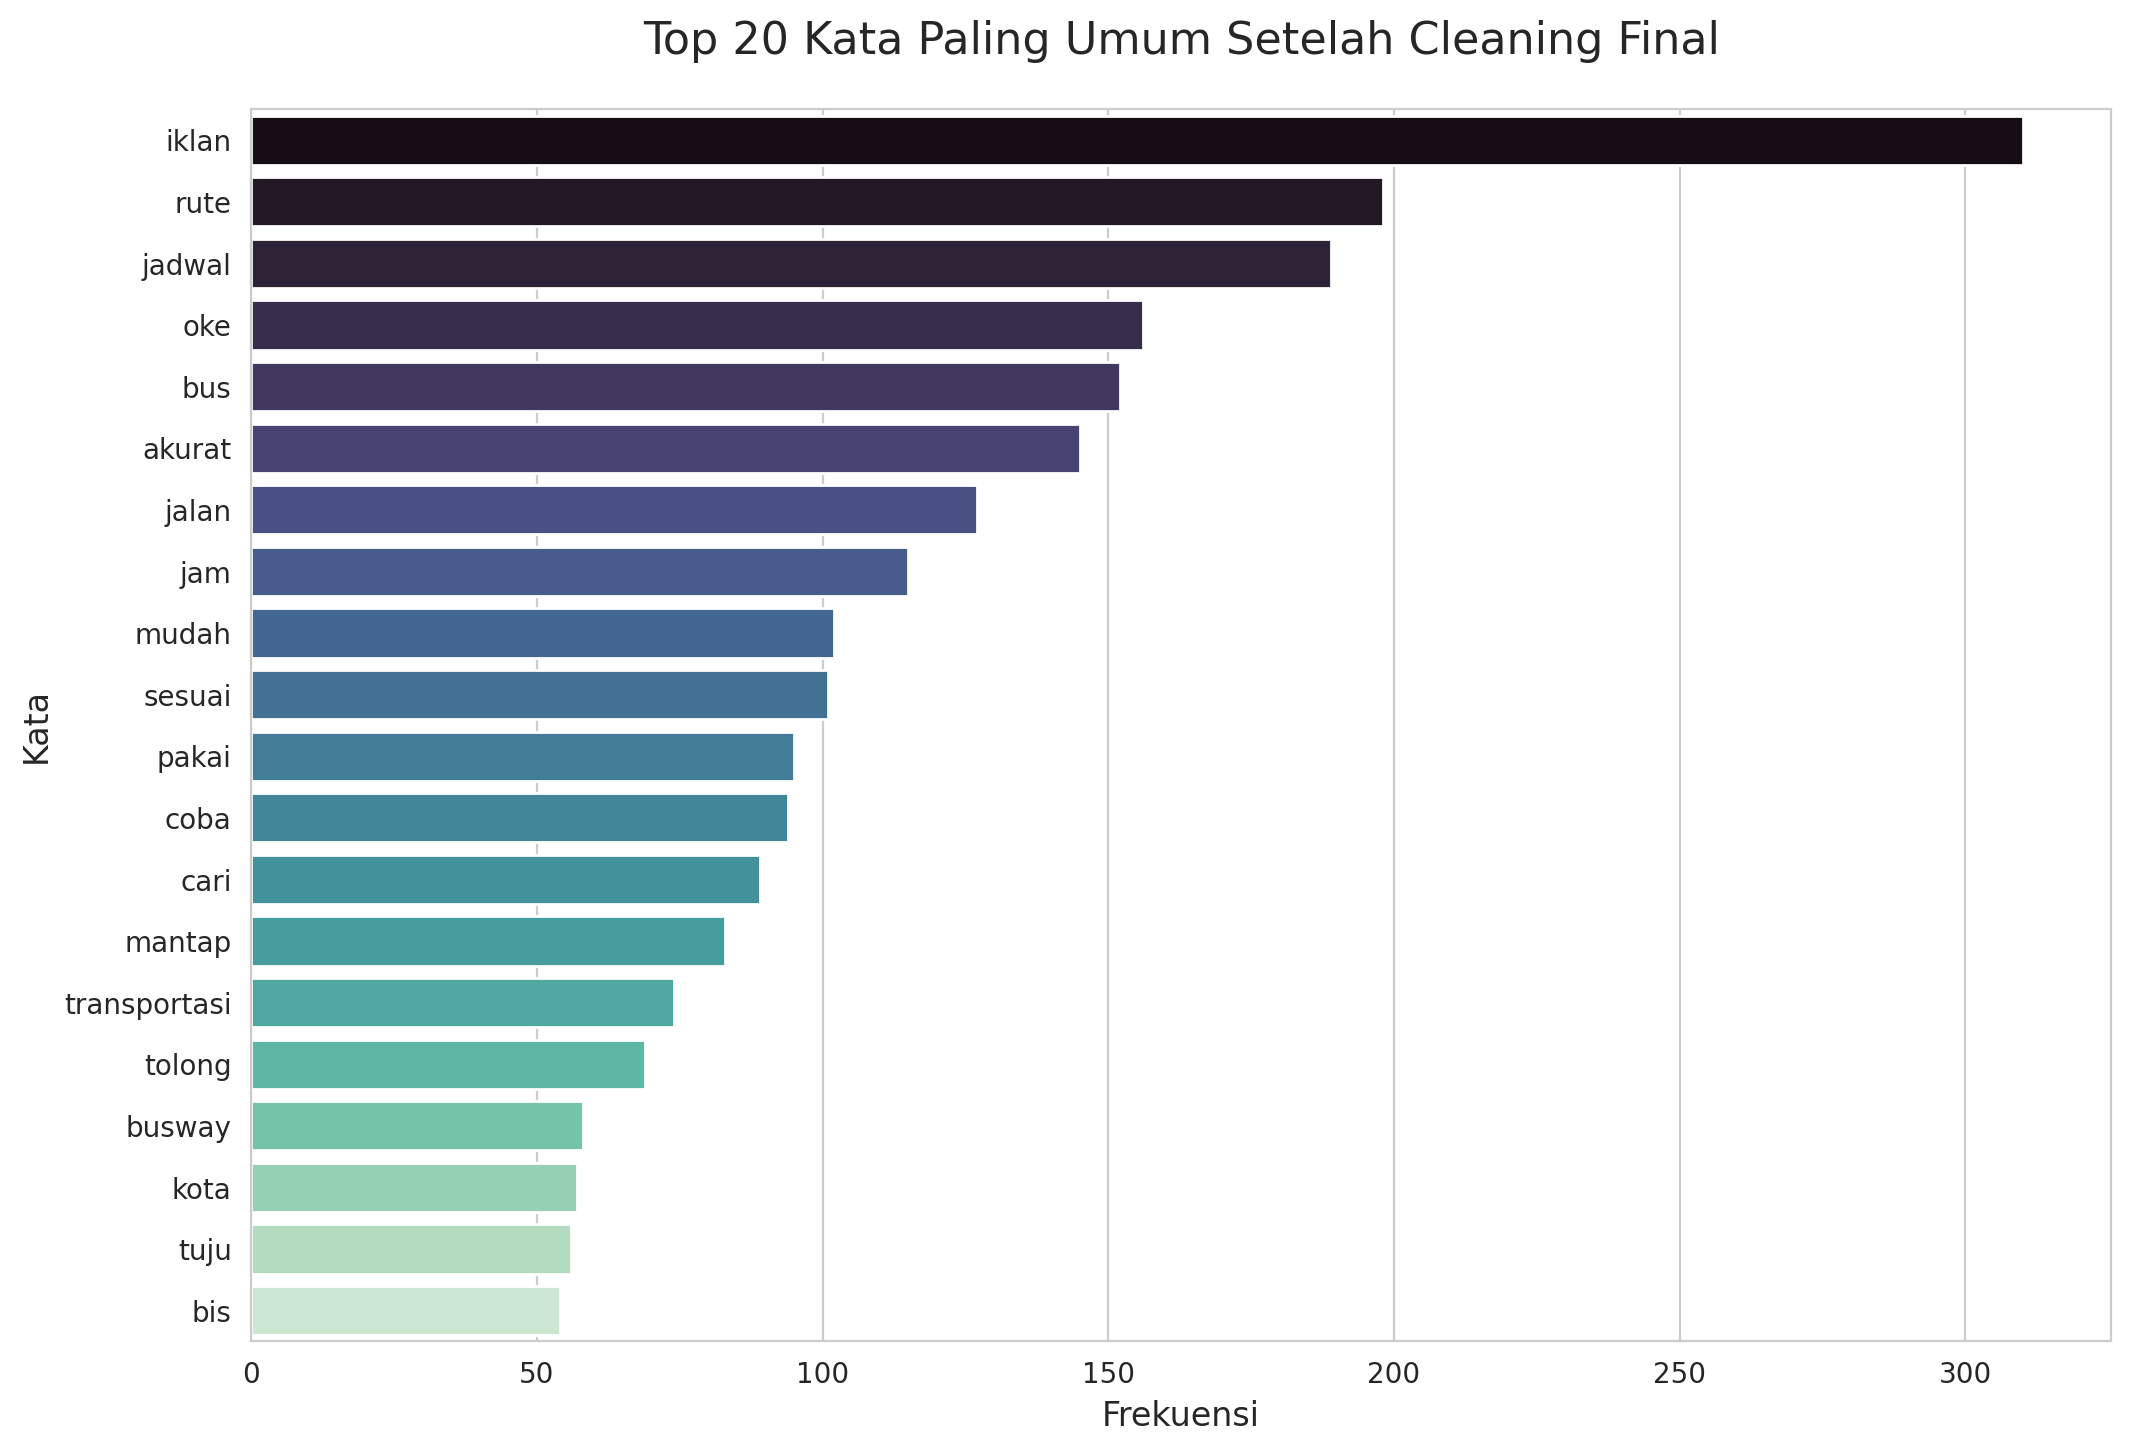

In [8]:
# Gabungkan semua token final
all_final_tokens = [word for tokens in df['final_tokens'] for word in tokens]
final_word_freq = Counter(all_final_tokens)

# Buat DataFrame dari 20 kata paling umum
most_common_final = pd.DataFrame(final_word_freq.most_common(20), columns=['Kata', 'Frekuensi'])

# Visualisasi
plt.figure(figsize=(12, 8))
sns.barplot(x='Frekuensi', y='Kata', data=most_common_final, palette='mako')
plt.title('Top 20 Kata Paling Umum Setelah Cleaning Final', fontsize=16, pad=20)
plt.xlabel('Frekuensi', fontsize=12)
plt.ylabel('Kata', fontsize=12)
plt.show()